# RFM
1. 3개월 단위로 데이터 처리
2. R : 가장 최근을 1.0으로 지정하고 하루를 지날수록 1.0 - i/180으로 값 지정
3. F : 3개월 주문수 합산.  하루 2번 이상 주문한 경우에도 그대로 합산. 최대 금액(X) 기준으로 N/X로 값 지정
4. M : 3개월 결제 금액 합산. 최대 금액(Y) 기준으로 N/Y로 값 지정
5. (R + F + M) / 3
6. 0.2 단위로 5단계 구분
7. 12월 ~ 5월까지 고객별 등급 저장

In [1]:
import glob
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

In [2]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
def recency(base, gap, rank_by_mber):
    return (1.0 - gap/base) if rank_by_mber == 1 else 0

In [58]:
unit = 90
to_date = pd.to_datetime("2020-11-30")
from_date = to_date - pd.to_timedelta(unit, unit='d')
files = glob.glob("/Users/choisj2/data/ml-mart/rds/rfm/**/**/**/*.csv")
colnames=['ORDER_REGIST_DATE', 'ORDRR_MBER_NO', 'ORDER_CNT', 'ORDER_DETAIL_CNT', 'ORDER_DETAIL_DSCNT_PC_SUM', 'ORDER_DETAIL_SELL_PC_SUM']
dtypes={'ORDER_REGIST_DATE':'str', 'ORDRR_MBER_NO':'int64', 'ORDER_CNT':'int64', 'ORDER_DETAIL_CNT':'int64', 'ORDER_DETAIL_DSCNT_PC_SUM':'int64', 'ORDER_DETAIL_SELL_PC_SUM':'int64'}
bins = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
bins_label = ['1등급','2등급','3등급','4등급','5등급']

In [59]:
from_date, to_date

(Timestamp('2020-09-01 00:00:00'), Timestamp('2020-11-30 00:00:00'))

In [128]:
%%time
df = pd.concat([pd.read_csv(file, names=colnames, dtype=dtypes, header=None, parse_dates=['ORDER_REGIST_DATE']) for file in files], axis=0, ignore_index=True)
df['GAP'] = (to_date - df['ORDER_REGIST_DATE']).dt.days
df = df[(df['GAP'] >= 0) & (df['GAP'] <= unit) & (df['ORDRR_MBER_NO'] > 0)]
df['RANK_BY_MBER'] = df.groupby(['ORDRR_MBER_NO']).cumcount() + 1
df['RECENCY'] = df[['GAP', 'RANK_BY_MBER']].apply(lambda x : recency(unit, x[0], x[1]), axis=1)

In [129]:
%%time
dfg = df.groupby(['ORDRR_MBER_NO']).sum().reset_index()
dfg['FREQUENCY'] = dfg['ORDER_CNT'] / dfg['ORDER_CNT'].max()
dfg['MONETARY'] = dfg['ORDER_DETAIL_DSCNT_PC_SUM'] / dfg['ORDER_DETAIL_DSCNT_PC_SUM'].max()
dfg['RFM'] = (dfg['RECENCY'] + dfg['FREQUENCY'] + dfg['MONETARY']) / 3
dfg['GRADE'] = pd.cut(dfg['RFM'], bins, right=True, labels=bins_label)

CPU times: user 671 ms, sys: 208 ms, total: 878 ms
Wall time: 877 ms


## Outliers 2020-09-01 ~ 2021-11-30

In [130]:
df['ORDER_REGIST_DATE'].min(),df['ORDER_REGIST_DATE'].max()

(Timestamp('2020-09-01 00:00:00'), Timestamp('2020-11-30 00:00:00'))

In [152]:
np.percentile(dfg['ORDER_CNT'], 99), np.percentile(dfg['ORDER_DETAIL_CNT'], 99), np.percentile(dfg['ORDER_DETAIL_DSCNT_PC_SUM'], 99)

(23.0, 34.0, 668458.8)

In [173]:
dfog = df.groupby(['ORDRR_MBER_NO']).sum().reset_index()

q_oc = np.percentile(dfog['ORDER_CNT'], 99)
q_odc = np.percentile(dfog['ORDER_DETAIL_CNT'], 99)
q_dps = np.percentile(dfog['ORDER_DETAIL_DSCNT_PC_SUM'], 90)

dfog_oc = dfog['ORDER_CNT']
dfog_odc = dfog['ORDER_DETAIL_CNT']
dfog_dps = dfog['ORDER_DETAIL_DSCNT_PC_SUM']

dfog_oc_idx =  dfog_oc[dfog_oc > q_oc].index
dfog_odc_idx =  dfog_odc[dfog_odc > q_odc ].index
dfog_dps_idx =  dfog_dps[dfog_dps > q_dps ].index

dfog.loc[dfog_oc_idx, 'ORDER_CNT'] = q_oc
dfog.loc[dfog_odc_idx, 'ORDER_DETAIL_CNT'] = q_odc
dfog.loc[dfog_dps_idx, 'ORDER_DETAIL_DSCNT_PC_SUM'] = q_dps

dfog['FREQUENCY'] = dfog['ORDER_CNT'] / dfog['ORDER_CNT'].max()
dfog['MONETARY'] = dfog['ORDER_DETAIL_DSCNT_PC_SUM'] / dfog['ORDER_DETAIL_DSCNT_PC_SUM'].max()
dfog['RFM'] = (dfog['RECENCY'] + dfog['FREQUENCY'] + dfog['MONETARY']) / 3
dfog['GRADE'] = pd.cut(dfog['RFM'], bins, right=True, labels=bins_label)

In [174]:
q_oc, q_odc, q_dps

(23.0, 34.0, 240860.0)

<AxesSubplot:>

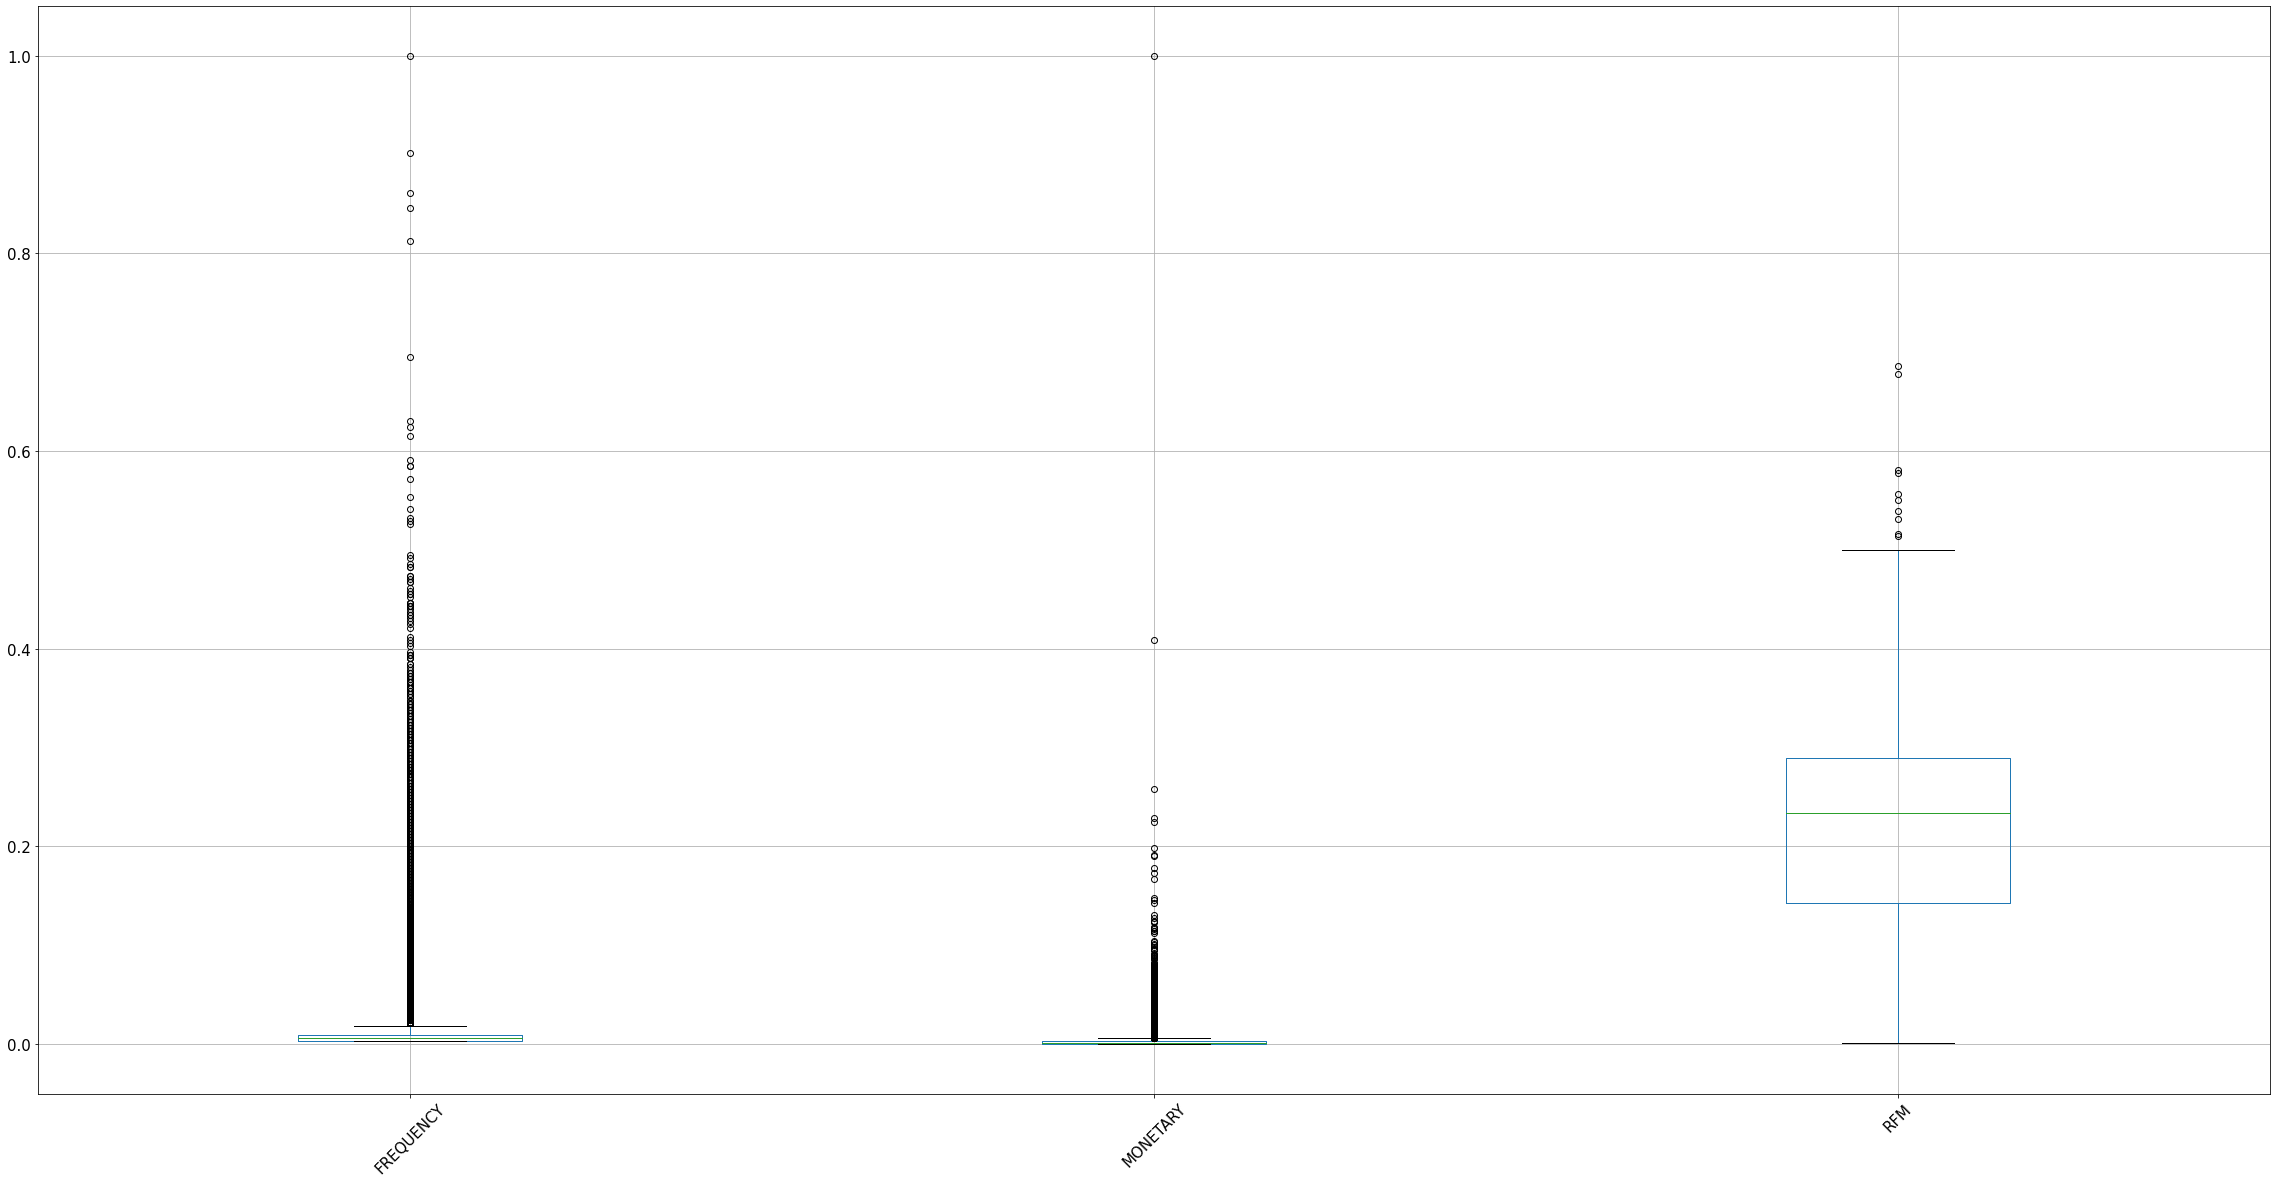

In [175]:
dfg.boxplot(column=['FREQUENCY','MONETARY', 'RFM'], rot=45, fontsize=15, figsize=(40, 20))

<AxesSubplot:>

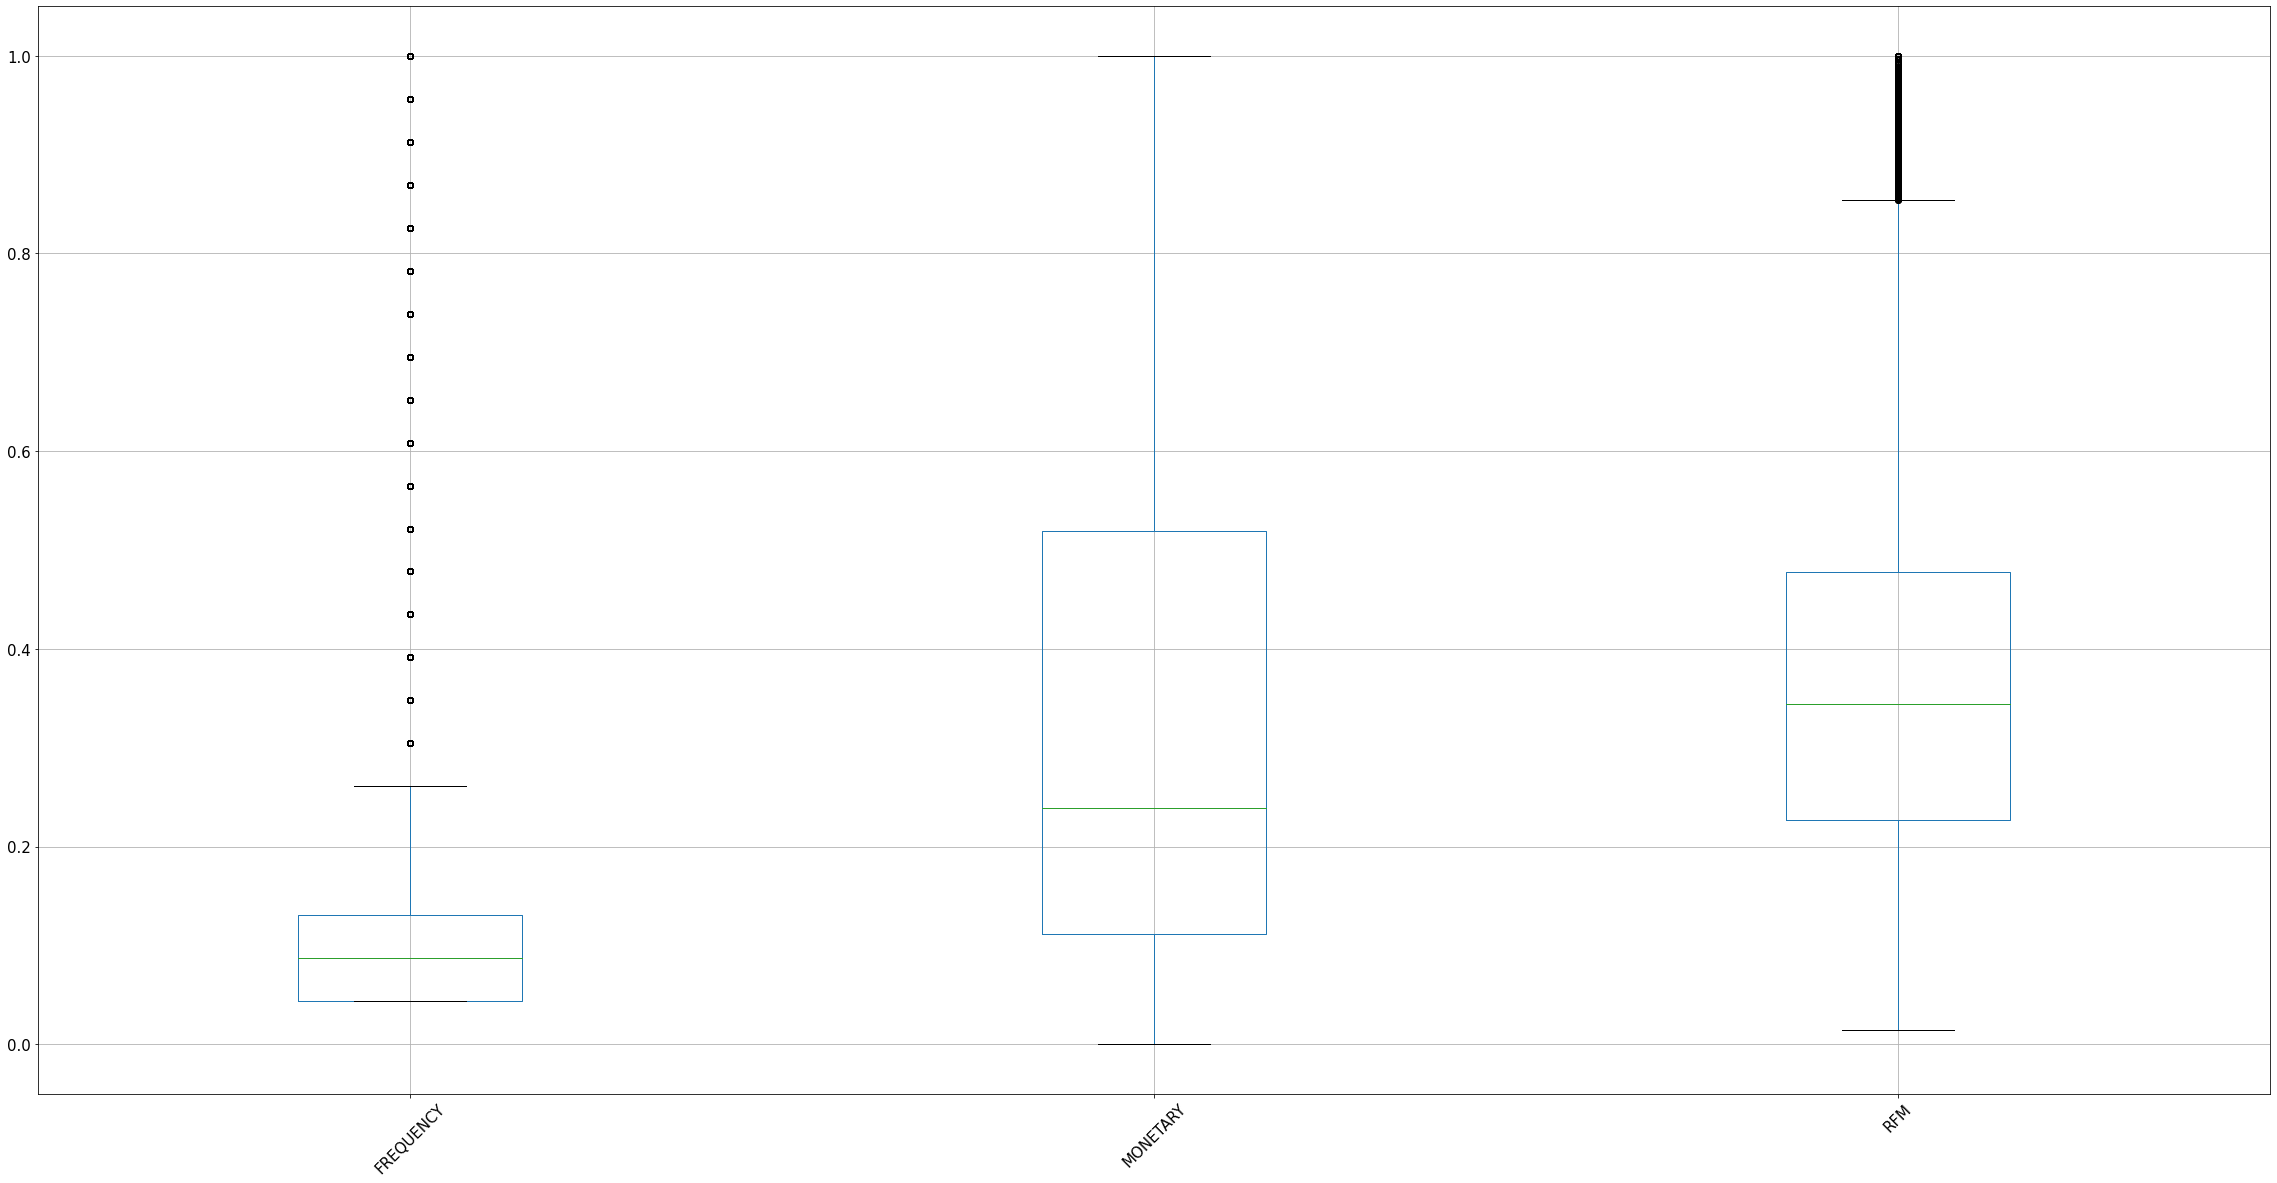

In [176]:
dfog.boxplot(column=['FREQUENCY', 'MONETARY', 'RFM'], rot=45, fontsize=15, figsize=(40, 20))

In [177]:
dfg.describe()

,ORDRR_MBER_NO,ORDER_CNT,ORDER_DETAIL_CNT,ORDER_DETAIL_DSCNT_PC_SUM,ORDER_DETAIL_SELL_PC_SUM,GAP,RANK_BY_MBER,RECENCY,FREQUENCY,MONETARY,RFM
count,890313.00000,890313.00000,890313.00000,890313.00000,890313.00000,890313.00000,890313.00000,890313.00000,890313.00000,890313.00000,890313.00000
mean,2397208.10843,3.24555,5.22004,103587.91355,133034.61092,113.65034,8.08168,0.61245,0.00999,0.00233,0.20825
std,1288849.17402,5.09156,7.58816,155745.49379,201351.48359,134.66109,24.68615,0.28525,0.01567,0.00350,0.09665
min,1.00000,1.00000,1.00000,10.00000,10.00000,0.00000,1.00000,0.00000,0.00308,0.00000,0.00103
25%,1275371.00000,1.00000,1.00000,26800.00000,32000.00000,36.00000,1.00000,0.42222,0.00308,0.00060,0.14329
50%,2377649.00000,2.00000,3.00000,57680.00000,72900.00000,75.00000,3.00000,0.68889,0.00615,0.00130,0.23432
75%,3666557.00000,3.00000,6.00000,125090.00000,161400.00000,140.00000,6.00000,0.85556,0.00923,0.00281,0.28998
max,4419051.00000,325.00000,931.00000,44492200.00000,60957700.00000,3542.00000,2850.00000,1.00000,1.00000,1.00000,0.68595


In [178]:
dfog.describe()

,ORDRR_MBER_NO,ORDER_CNT,ORDER_DETAIL_CNT,ORDER_DETAIL_DSCNT_PC_SUM,ORDER_DETAIL_SELL_PC_SUM,GAP,RANK_BY_MBER,RECENCY,FREQUENCY,MONETARY,RFM
count,890313.00000,890313.00000,890313.00000,890313.00000,890313.00000,890313.00000,890313.00000,890313.00000,890313.00000,890313.00000,890313.00000
mean,2397208.10843,3.08935,5.03135,84972.07951,133034.61092,113.65034,8.08168,0.61245,0.13432,0.35279,0.36652
std,1288849.17402,3.65678,5.86850,74822.55289,201351.48359,134.66109,24.68615,0.28525,0.15899,0.31065,0.19661
min,1.00000,1.00000,1.00000,10.00000,10.00000,0.00000,1.00000,0.00000,0.04348,0.00004,0.01463
25%,1275371.00000,1.00000,1.00000,26800.00000,32000.00000,36.00000,1.00000,0.42222,0.04348,0.11127,0.22651
50%,2377649.00000,2.00000,3.00000,57680.00000,72900.00000,75.00000,3.00000,0.68889,0.08696,0.23948,0.34421
75%,3666557.00000,3.00000,6.00000,125090.00000,161400.00000,140.00000,6.00000,0.85556,0.13043,0.51935,0.47770
max,4419051.00000,23.00000,34.00000,240860.00000,60957700.00000,3542.00000,2850.00000,1.00000,1.00000,1.00000,1.00000


## 20.09~21.05월 이상값 확인

In [171]:
df_0 = pd.concat([pd.read_csv(file, names=colnames, dtype=dtypes, header=None, parse_dates=['ORDER_REGIST_DATE']) for file in files], axis=0, ignore_index=True)

In [172]:
df_g_0 = df_0.groupby(['ORDRR_MBER_NO']).sum().reset_index()
q_oc_0 = np.percentile(df_g_0['ORDER_CNT'], 75)
q_odc_0 = np.percentile(df_g_0['ORDER_DETAIL_CNT'], 75)
q_dps_0 = np.percentile(df_g_0['ORDER_DETAIL_DSCNT_PC_SUM'], 75)

In [185]:
q_oc_0, q_odc_0, q_dps_0

(5.0, 9.0, 187875.0)

# 09~11월 이상값 확인

## 9월~11월

In [76]:
df_1 = df_0[(df_0['ORDER_REGIST_DATE'] >= pd.to_datetime("2020-09-01")) & (df_0['ORDER_REGIST_DATE'] <= pd.to_datetime("2020-11-30"))]

In [77]:
df_g_1 = df_1.groupby(['ORDRR_MBER_NO']).sum().reset_index()
q_oc_1 = np.percentile(df_g_1['ORDER_CNT'], 75)
q_odc_1 = np.percentile(df_g_1['ORDER_DETAIL_CNT'], 75)
q_dps_1 = np.percentile(df_g_1['ORDER_DETAIL_DSCNT_PC_SUM'], 75)

In [78]:
q_oc_1, q_odc_1, q_dps_1

(3.0, 6.0, 125090.0)

## 10월~12월

In [79]:
df_2 = df_0[(df_0['ORDER_REGIST_DATE'] >= pd.to_datetime("2020-10-01")) & (df_0['ORDER_REGIST_DATE'] <= pd.to_datetime("2020-12-31"))]

In [80]:
df_g_2 = df_2.groupby(['ORDRR_MBER_NO']).sum().reset_index()
q_oc_2 = np.percentile(df_g_2['ORDER_CNT'], 75)
q_odc_2 = np.percentile(df_g_2['ORDER_DETAIL_CNT'], 75)
q_dps_2 = np.percentile(df_g_2['ORDER_DETAIL_DSCNT_PC_SUM'], 75)

In [81]:
q_oc_2, q_odc_2, q_dps_2

(3.0, 6.0, 132940.0)

## 11월~01월

In [82]:
df_3 = df_0[(df_0['ORDER_REGIST_DATE'] >= pd.to_datetime("2020-11-01")) & (df_0['ORDER_REGIST_DATE'] <= pd.to_datetime("2021-01-31"))]

In [83]:
df_g_3 = df_3.groupby(['ORDRR_MBER_NO']).sum().reset_index()
q_oc_3 = np.percentile(df_g_3['ORDER_CNT'], 75)
q_odc_3 = np.percentile(df_g_3['ORDER_DETAIL_CNT'], 75)
q_dps_3 = np.percentile(df_g_3['ORDER_DETAIL_DSCNT_PC_SUM'], 75)

In [84]:
q_oc_3, q_odc_3, q_dps_3

(3.0, 6.0, 132000.0)

## 12월~02월

In [85]:
df_4 = df_0[(df_0['ORDER_REGIST_DATE'] >= pd.to_datetime("2020-12-01")) & (df_0['ORDER_REGIST_DATE'] <= pd.to_datetime("2021-02-28"))]

In [86]:
df_g_4 = df_4.groupby(['ORDRR_MBER_NO']).sum().reset_index()
q_oc_4 = np.percentile(df_g_4['ORDER_CNT'], 75)
q_odc_4 = np.percentile(df_g_4['ORDER_DETAIL_CNT'], 75)
q_dps_4 = np.percentile(df_g_4['ORDER_DETAIL_DSCNT_PC_SUM'], 75)

In [87]:
q_oc_4, q_odc_4, q_dps_4

(3.0, 5.0, 122800.0)

## histrogram

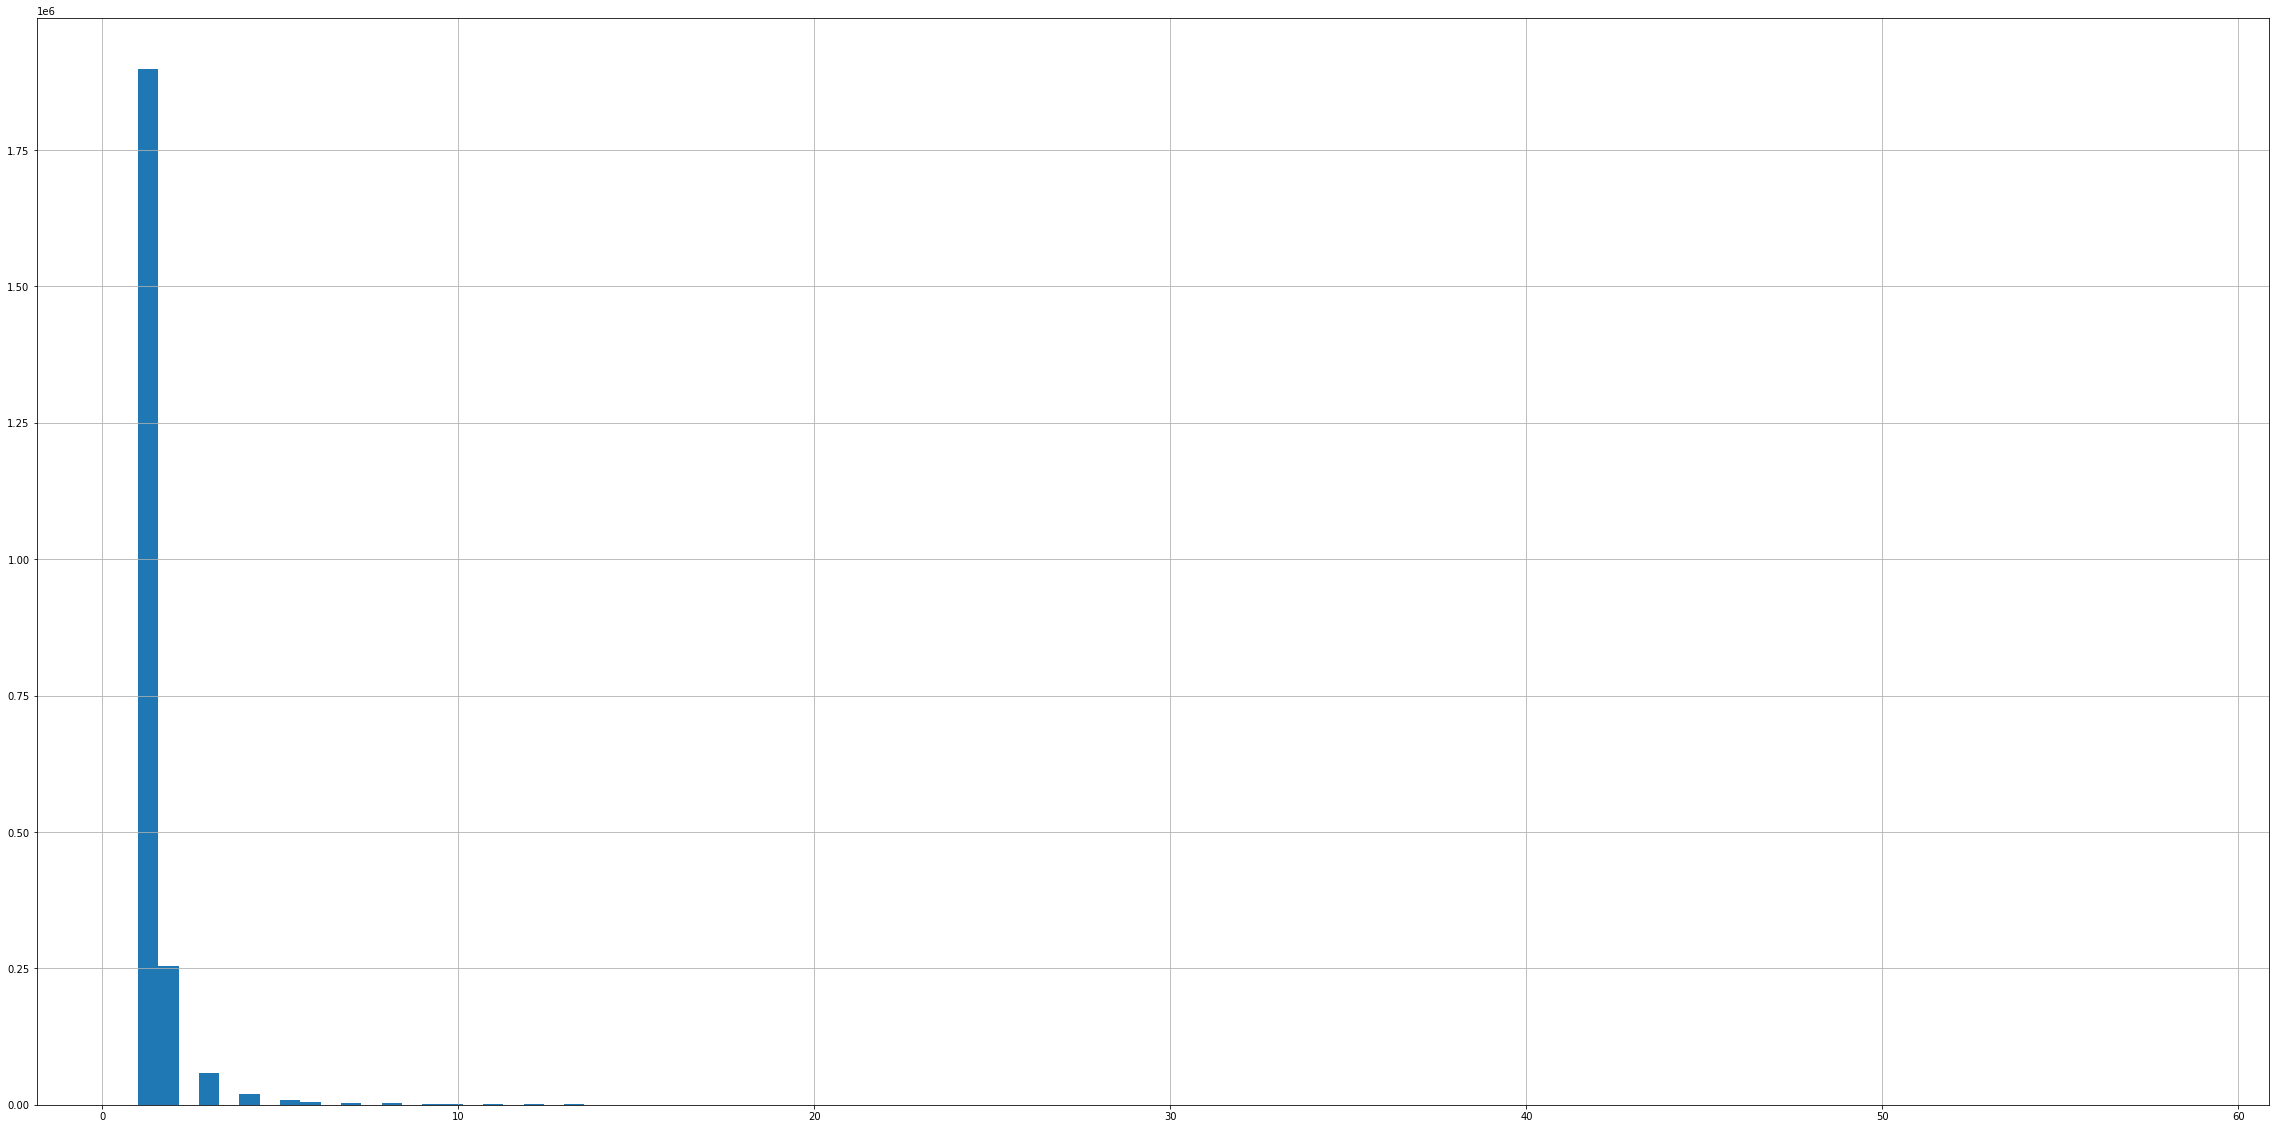

In [182]:
df_g_4 = df['ORDER_CNT'].hist(bins=100, figsize=(40, 20))

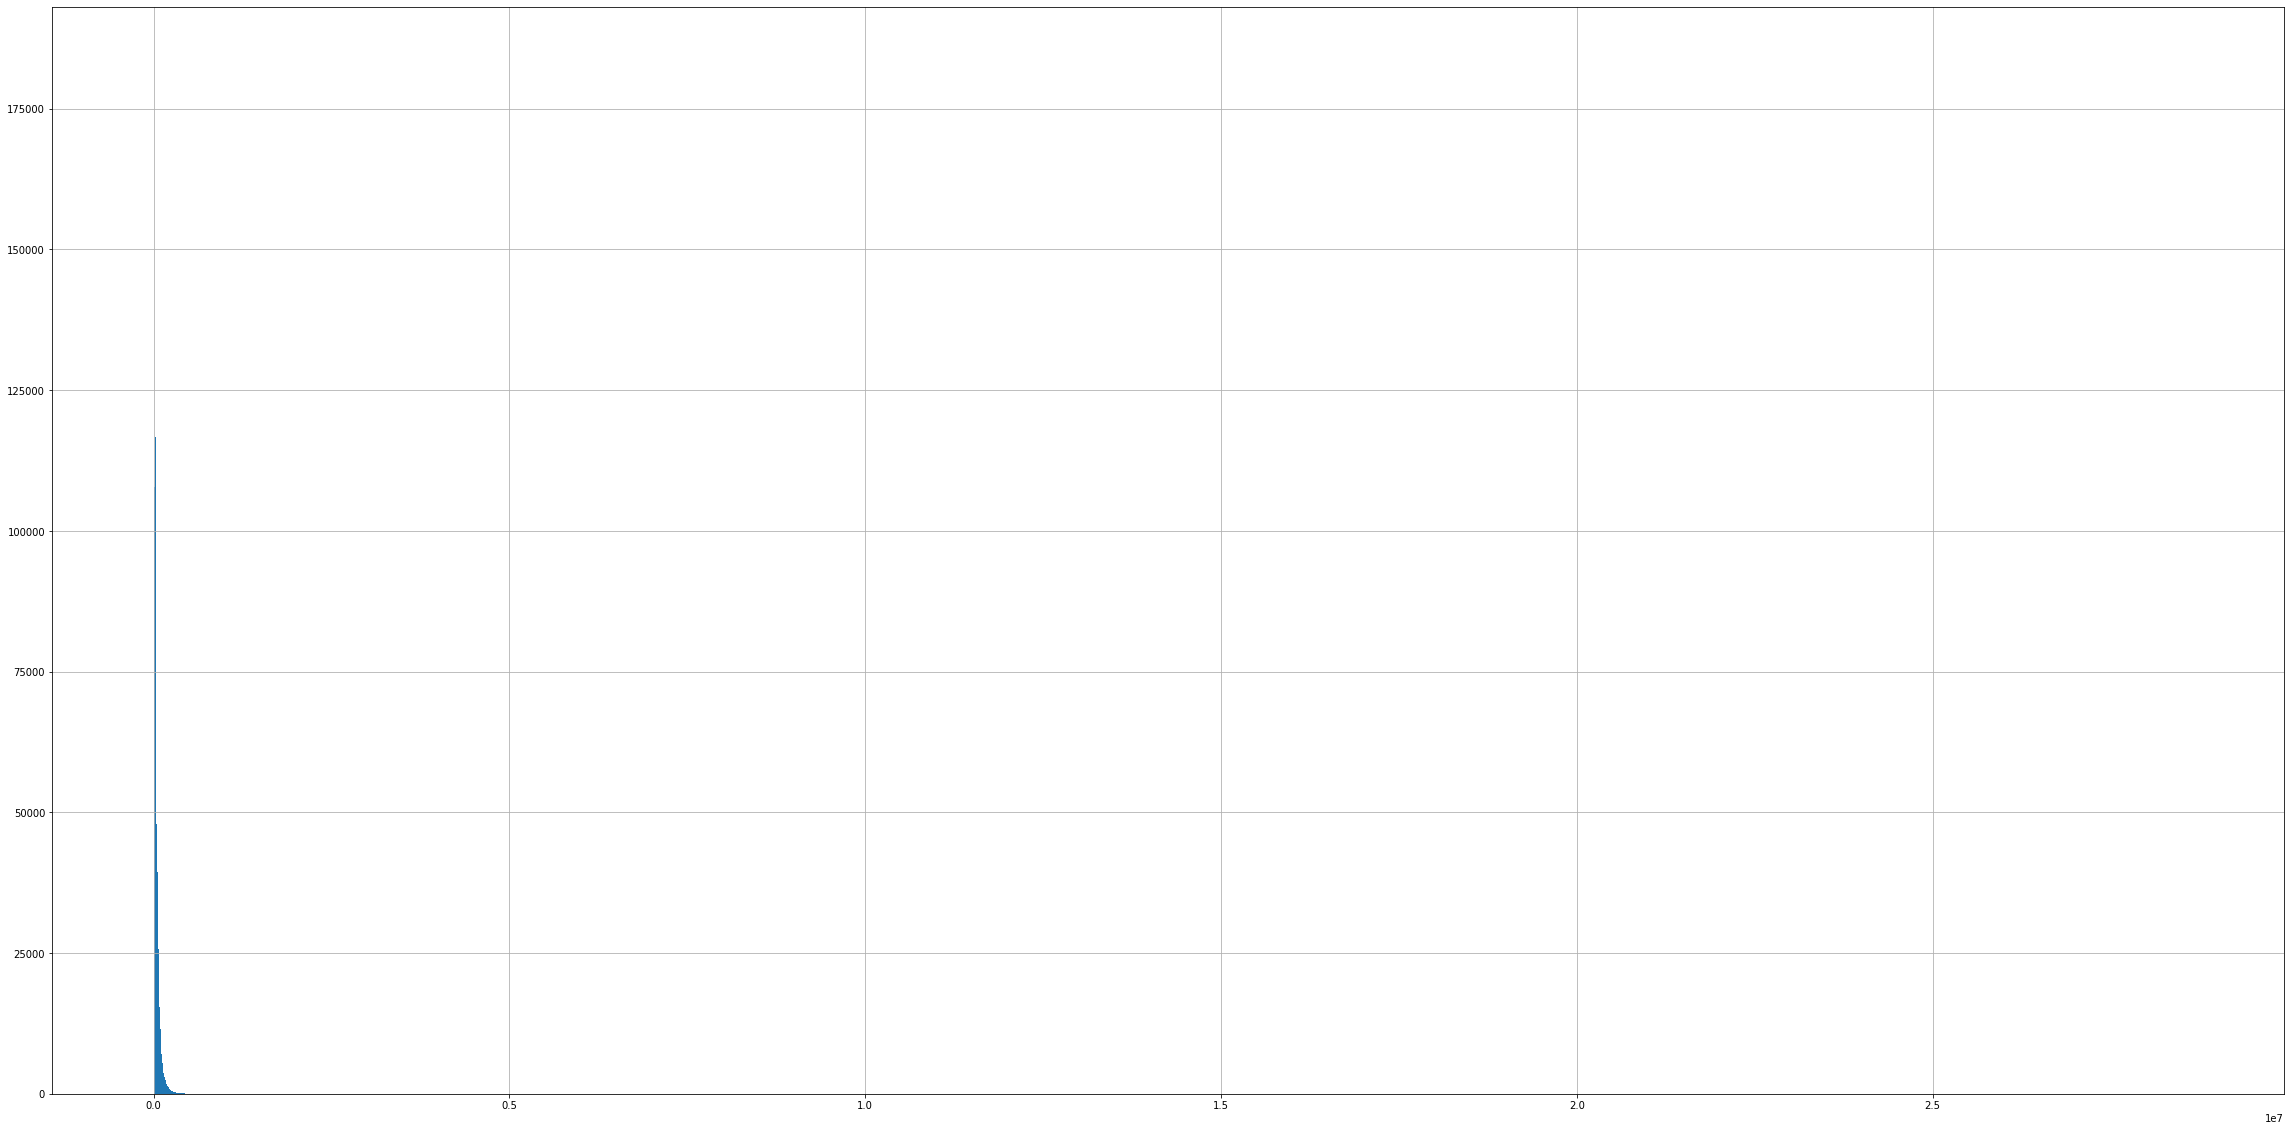

In [184]:
df_g_4 = df['ORDER_DETAIL_DSCNT_PC_SUM'].hist(bins=10000, figsize=(40, 20))